# **Intrusion Detection System (IDS) - Analisis Dataset CSE-CIC-IDS2018**

---

| Informasi | Detail |
|:---|:---|
| **Nama** | Josia Given Santoso |
| **NIM** | 36230035 |
| **Mata Kuliah** | Keamanan Data |
| **Dosen Pengampu** | Alaniah Nisrina, B.Eng., M.Eng. |

---

## Ringkasan Proyek

Notebook ini menyajikan pipeline **Machine Learning end-to-end** untuk membangun sistem deteksi intrusi jaringan (*Network Intrusion Detection System*). Dataset yang digunakan adalah **CSE-CIC-IDS2018** dari Canadian Institute for Cybersecurity.

### Struktur Notebook

| No | Tahap | Deskripsi |
|:---:|:---|:---|
| 1 | Import Library | Memuat seluruh dependensi yang diperlukan |
| 2 | Read Data | Membaca dataset dari format Parquet |
| 3 | Data Cleaning | Membersihkan nilai null, infinite, dan duplikat |
| 4 | EDA | Eksplorasi visual distribusi data |
| 5 | Data Preparation | Splitting, Scaling, dan SMOTE |
| 6 | Modelling | Pelatihan multi-model klasifikasi |
| 7 | Evaluation | Metrik performa dan visualisasi hasil |

# 0. Load Data

Bagian ini memuat pustaka Python yang dibutuhkan:

- **Data Processing**: `pandas`, `numpy`, `dask`
- **Visualisasi**: `matplotlib`, `seaborn`
- **Machine Learning**: `scikit-learn`, `xgboost`, `imblearn`
- **Utilities**: `os`, `warnings`, `time`, `joblib`

---

## Download dan Konversi Data

- Dataset diunduh dari Kaggle.
- CSV dikonversi ke Parquet menggunakan Dask agar lebih cepat diproses.

```python
# Contoh (tidak dijalankan)
import dask.dataframe as dd
import os

csv_file = "IDS_2018.csv"
parquet_file = "IDS_2018_Final.parquet"

if not os.path.exists(parquet_file):
    ddf = dd.read_csv(csv_file)
    ddf.to_parquet(parquet_file, engine="pyarrow", write_index=False)


In [ ]:
# import os
# import gdown
# import dask_cudf
# from dask.distributed import Client
# from dask_cuda import LocalCUDACluster

# # =====================================================
# # 0. DOWNLOAD DATA
# # =====================================================
# file_id = '1mgIHPr6jcQTF0WbeU1t9xAoBfAWxDXXr'
# url = f'https://drive.google.com/uc?id={file_id}'
# FILE_PATH = '/content/IDS_2018_Final.parquet'

# if not os.path.exists(FILE_PATH):
#     print("Downloading dataset...")
#     gdown.download(url, FILE_PATH, quiet=False)
# else:
#     print("Dataset already exists.")

# print("="*50)
# print("STARTING ADVANCED EDA (FULL DASK-GPU)")
# print("="*50)

# # =====================================================
# # 1. SETUP GPU CLUSTER
# # =====================================================
# print("\n[1] Initializing Dask CUDA Cluster...")
# try:
#     cluster = LocalCUDACluster(rmm_pool_size="12GB", jit_unspill=True)
#     client = Client(cluster)
#     print(f"Cluster Ready: {client.dashboard_link}")
# except Exception as e:
#     print(f"Cluster fallback: {e}")
#     client = Client()

# # =====================================================
# # 2. LAZY LOADING
# # =====================================================
# print("\n[2] Reading Parquet lazily...")
# try:
#     ddf = dask_cudf.read_parquet(FILE_PATH)
#     print("Dataset opened!")
#     print(f"Partitions: {ddf.npartitions}")
#     print(f"Columns ({len(ddf.columns)}): {list(ddf.columns)[:5]} ...")
# except Exception as e:
#     print(f"Failed to read file: {e}")
#     exit()

# # =====================================================
# # 3. FUNCTION TO GET DATASET STATS
# # =====================================================
# def get_dask_stats(file_path, dataset_name="DATASET"):
#     print(f"\n{'='*20} {dataset_name} {'='*20}")
#     if not os.path.exists(file_path):
#         print(f"File not found: {file_path}")
#         return

#     try:
#         ddf = dask_cudf.read_parquet(file_path)
#         num_rows = len(ddf)
#         num_cols = len(ddf.columns)

#         print(f"File Path      : {file_path}")
#         print(f"Partitions     : {ddf.npartitions}")
#         print(f"Shape          : ({num_rows:,}, {num_cols})")
#         print(f"Columns        : {list(ddf.columns)}")
#         print(f"Dtypes         : {ddf.dtypes}")

#     except Exception as e:
#         print(f"Error reading stats: {e}")

# # =====================================================
# # 4. EXECUTE STATS CHECK
# # =====================================================
# get_dask_stats(FILE_PATH, "MAIN DATASET")


---
# **1. Import Library**

Bagian ini memuat seluruh pustaka Python yang dibutuhkan untuk proyek ini. Pustaka dikelompokkan berdasarkan fungsinya:

- **Data Processing**: `pandas`, `numpy`, `dask` untuk manipulasi data skala besar
- **Visualization**: `matplotlib`, `seaborn` untuk visualisasi statistik
- **Machine Learning**: `scikit-learn`, `xgboost`, `imblearn` untuk pemodelan
- **Utilities**: `os`, `warnings`, `time`, `joblib` untuk keperluan sistem

In [1]:
import os
import time
import warnings
import joblib

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from dask_ml.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("All libraries loaded successfully.")

All libraries loaded successfully.


---
# **2. Read Data**

Dataset **CSE-CIC-IDS2018** berukuran sangat besar (15+ juta baris). Untuk efisiensi, digunakan:

1. **Format Parquet**: Format kolom terkompresi yang jauh lebih efisien dibanding CSV
2. **Dask DataFrame**: Memungkinkan pemrosesan data yang melebihi kapasitas RAM
3. **Stratified Sampling**: Mengambil subset data (5%) dengan distribusi kelas terjaga

Sistem akan otomatis memeriksa apakah file sample sudah tersedia, jika tidak maka akan memproses dari file asli.

In [ ]:
import os
import gdown
import dask.dataframe as dd

# =====================================================
# CONFIG
# =====================================================
SAMPLE_FRAC = 0.05
RANDOM_STATE = 42

# =====================================================
# PATH DATASET
# =====================================================
current_dir = os.getcwd()

if os.path.exists(os.path.join(current_dir, "..", "datasets")):
    base_path = os.path.join(current_dir, "..", "datasets")
elif os.path.exists(os.path.join(current_dir, "datasets")):
    base_path = os.path.join(current_dir, "datasets")
else:
    base_path = os.path.join(current_dir, "datasets")
    os.makedirs(base_path, exist_ok=True)

percent_suffix = int(SAMPLE_FRAC * 100)
INPUT_FILE = os.path.join(base_path, "IDS_2018_Final.parquet")
OUTPUT_FILE = os.path.join(base_path, f"IDS_2018_Final_CLEAN_{percent_suffix}.parquet")

print(f"Input File:  {INPUT_FILE}")
print(f"Output File: {OUTPUT_FILE}")
print(f"Target Sampling: {percent_suffix}%")

# =====================================================
# DOWNLOAD DARI GOOGLE DRIVE
# =====================================================
file_id = "10t26j2usTSqdyzroWXqEPfoeoPcyU-NI"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(INPUT_FILE):
    print("🚀 Downloading dataset from Google Drive...")
    gdown.download(gdrive_url, INPUT_FILE, quiet=False)
else:
    print("✔ Dataset already exists, skipping download.")

# =====================================================
# SAMPLING DENGAN DASK
# =====================================================
print("🔹 Loading dataset with Dask...")
ddf = dd.read_parquet(INPUT_FILE)

print(f"🔹 Sampling {percent_suffix}% of dataset...")
ddf_sample = ddf.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)

print("🔹 Saving sampled dataset...")
ddf_sample.to_parquet(OUTPUT_FILE, engine="pyarrow", write_index=False)
print(f"✔ Sampled dataset saved: {OUTPUT_FILE}")

Input File:  d:\Dev_Drive\Coding Project Files\Uni_Assignment\UAS\36230035_KeamananData_UAS\notebooks\..\datasets\IDS_2018_Final.parquet
Output File: d:\Dev_Drive\Coding Project Files\Uni_Assignment\UAS\36230035_KeamananData_UAS\notebooks\..\datasets\IDS_2018_Final_CLEAN_5.parquet
Target Sampling: 5%


In [ ]:
import os
import gdown
import dask.dataframe as dd

# =====================================================
# CONFIG
# =====================================================
SAMPLE_FRAC = 0.05
RANDOM_STATE = 42

# =====================================================
# PATH DATASET
# =====================================================
current_dir = os.getcwd()

if os.path.exists(os.path.join(current_dir, "..", "datasets")):
    base_path = os.path.join(current_dir, "..", "datasets")
elif os.path.exists(os.path.join(current_dir, "datasets")):
    base_path = os.path.join(current_dir, "datasets")
else:
    base_path = os.path.join(current_dir, "datasets")
    os.makedirs(base_path, exist_ok=True)

percent_suffix = int(SAMPLE_FRAC * 100)
INPUT_FILE = os.path.join(base_path, "IDS_2018_Final.parquet")
OUTPUT_FILE = os.path.join(base_path, f"IDS_2018_Final_CLEAN_{percent_suffix}.parquet")

print(f"Input File:  {INPUT_FILE}")
print(f"Output File: {OUTPUT_FILE}")
print(f"Target Sampling: {percent_suffix}%")

# =====================================================
# DOWNLOAD DARI GOOGLE DRIVE
# =====================================================
file_id = "10t26j2usTSqdyzroWXqEPfoeoPcyU-NI"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(INPUT_FILE):
    print("🚀 Downloading dataset from Google Drive...")
    gdown.download(gdrive_url, INPUT_FILE, quiet=False)
else:
    print("✔ Dataset already exists, skipping download.")

# =====================================================
# SAMPLING DENGAN DASK
# =====================================================
print("🔹 Loading dataset with Dask...")
ddf = dd.read_parquet(INPUT_FILE)

print(f"🔹 Sampling {percent_suffix}% of dataset...")
ddf_sample = ddf.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)

print("🔹 Saving sampled dataset...")
ddf_sample.to_parquet(OUTPUT_FILE, engine="pyarrow", write_index=False)
print(f"✔ Sampled dataset saved: {OUTPUT_FILE}")



[INFO] Sampled file exists. Loading directly...
Loaded Rows: 515,614

[READY] Variable `ddf_final` loaded.


---
# **3. Data Cleaning**

Tahap pembersihan data meliputi beberapa langkah kritis:

| Langkah | Tujuan |
|:---|:---|
| Drop Kolom Tidak Relevan | Menghapus `Timestamp` yang tidak berguna untuk klasifikasi |
| Handle Infinite Values | Mengganti `inf` dan `-inf` dengan `NaN` |
| Remove Missing Values | Menghapus baris dengan nilai `NaN` |
| Clean Column Names | Membersihkan spasi pada nama kolom |
| Remove Artifacts | Menghapus baris dengan label "Label" (header artifact) |
| Label Grouping | Mengelompokkan 14+ kategori serangan menjadi 4 kelas utama |

### Pengelompokan Label

| Kategori | Jenis Serangan |
|:---|:---|
| Benign | Traffic normal |
| DDoS | DoS, DDoS, HOIC, LOIC |
| Brute Force | SSH, FTP, Web Attack |
| Other | Bot, Infiltration, SQL Injection |

In [4]:
ddf = ddf_final

print("=" * 80)
print("                        INITIAL DATASET INSPECTION")
print("=" * 80)

total_rows_init = ddf.shape[0].compute()
total_cols = len(ddf.columns)

print(f"Total Rows (Raw) : {total_rows_init:,}")
print(f"Total Columns    : {total_cols}")

print("\n[Data Types Summary]")
print(ddf.dtypes)

print("\n[Checking Missing Values...]")
missing_values = ddf.isnull().sum().compute()
missing_count = missing_values[missing_values > 0]

if not missing_count.empty:
    print(missing_count)
else:
    print("No missing values detected.")

                        INITIAL DATASET INSPECTION
Total Rows (Raw) : 515,614
Total Columns    : 78

[Data Types Summary]
Protocol                   float32
Flow Duration              float32
Tot Fwd Pkts               float32
Tot Bwd Pkts               float32
TotLen Fwd Pkts            float32
                        ...       
Idle Mean                  float32
Idle Std                   float32
Idle Max                   float32
Idle Min                   float32
Label              string[pyarrow]
Length: 78, dtype: object

[Checking Missing Values...]
No missing values detected.


In [5]:
print("=" * 80)
print("                         DATA CLEANING PIPELINE")
print("=" * 80)

cols_to_drop = ['Timestamp']
existing_cols_to_drop = [c for c in cols_to_drop if c in ddf.columns]

if existing_cols_to_drop:
    print(f"Dropping columns: {existing_cols_to_drop}")
    ddf = ddf.drop(existing_cols_to_drop, axis=1)

print("Replacing Infinity with NaN and dropping invalid rows...")
ddf = ddf.replace([np.inf, -np.inf], np.nan)
ddf = ddf.dropna()

ddf.columns = [c.strip() for c in ddf.columns]

ddf = ddf[ddf['Label'] != 'Label']

total_rows_clean = ddf.shape[0].compute()
dropped_count = total_rows_init - total_rows_clean

print(f"Rows BEFORE Cleaning : {total_rows_init:,}")
print(f"Rows AFTER Cleaning  : {total_rows_clean:,}")
print(f"Total Rows Dropped   : {dropped_count:,}")

                         DATA CLEANING PIPELINE
Replacing Infinity with NaN and dropping invalid rows...
Rows BEFORE Cleaning : 515,614
Rows AFTER Cleaning  : 515,485
Total Rows Dropped   : 129


In [6]:
print("\n[Applying Simplified Label Grouping]")

def group_labels(label):
    label = str(label).lower()
    if 'benign' in label:
        return 'Benign'
    elif 'dos' in label or 'ddos' in label or 'hoic' in label or 'loic' in label:
        return 'DDoS'
    elif 'brute' in label or 'ssh' in label or 'ftp' in label or 'web' in label:
        return 'Brute Force'
    else:
        return 'Other'

ddf['Label_Category'] = ddf['Label'].map(group_labels, meta=('Label', object))
ddf = ddf.drop('Label', axis=1)

print("New Label Distribution:")
category_counts = ddf['Label_Category'].value_counts().compute()
print(category_counts)

label_map = {val: i for i, val in enumerate(sorted(category_counts.index.tolist()))}
print(f"\nEncoding Map: {label_map}")

ddf['Label_Encoded'] = ddf['Label_Category'].map(label_map, meta=('Label_Category', int))

feature_cols = [c for c in ddf.columns if c not in ['Label_Category', 'Label_Encoded']]
ddf[feature_cols] = ddf[feature_cols].astype('float32')

print(f"\nFinal Feature Count: {len(feature_cols)}")
print("Data Cleaning Complete.")


[Applying Simplified Label Grouping]
New Label Distribution:
Label_Category
Brute Force      4696
Benign         449494
DDoS            48392
Other           12903
Name: count, dtype: int64

Encoding Map: {'Benign': 0, 'Brute Force': 1, 'DDoS': 2, 'Other': 3}

Final Feature Count: 77
Data Cleaning Complete.


---
# **4. Exploratory Data Analysis (EDA)**

Eksplorasi data dilakukan untuk memahami karakteristik dataset sebelum pemodelan:

1. **Distribusi Target**: Visualisasi proporsi setiap kategori serangan
2. **Correlation Heatmap**: Mengidentifikasi fitur yang berkorelasi tinggi
3. **Feature Distribution**: Analisis distribusi fitur kunci per kategori serangan

Dataset network traffic umumnya memiliki karakteristik:
- **Class Imbalance**: Traffic benign jauh lebih banyak dari serangan
- **High Dimensionality**: 78+ fitur network flow
- **Skewed Distributions**: Nilai ekstrem pada fitur tertentu

                    EXPLORATORY DATA ANALYSIS (EDA)
Sampling clean data for visualization (2% fraction)...


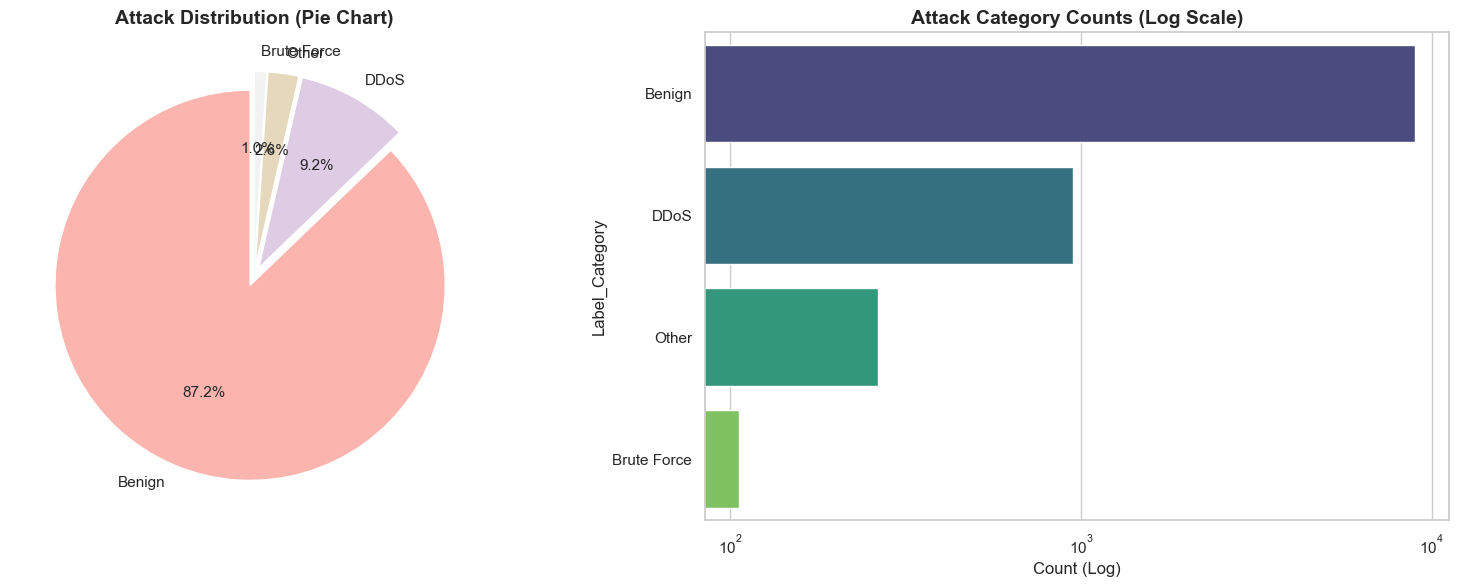

In [7]:
print("=" * 80)
print("                    EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 80)

print("Sampling clean data for visualization (2% fraction)...")
df_vis = ddf.sample(frac=0.02, random_state=42).compute()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_vis['Label_Category'].value_counts().plot.pie(
    ax=axes[0], autopct='%1.1f%%', startangle=90, cmap='Pastel1',
    explode=[0.05] * len(category_counts)
)
axes[0].set_title("Attack Distribution (Pie Chart)", fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

sns.countplot(
    data=df_vis, y='Label_Category', ax=axes[1],
    order=df_vis['Label_Category'].value_counts().index, palette='viridis'
)
axes[1].set_title("Attack Category Counts (Log Scale)", fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_xlabel("Count (Log)")

plt.tight_layout()
plt.show()

Generating Correlation Heatmap...


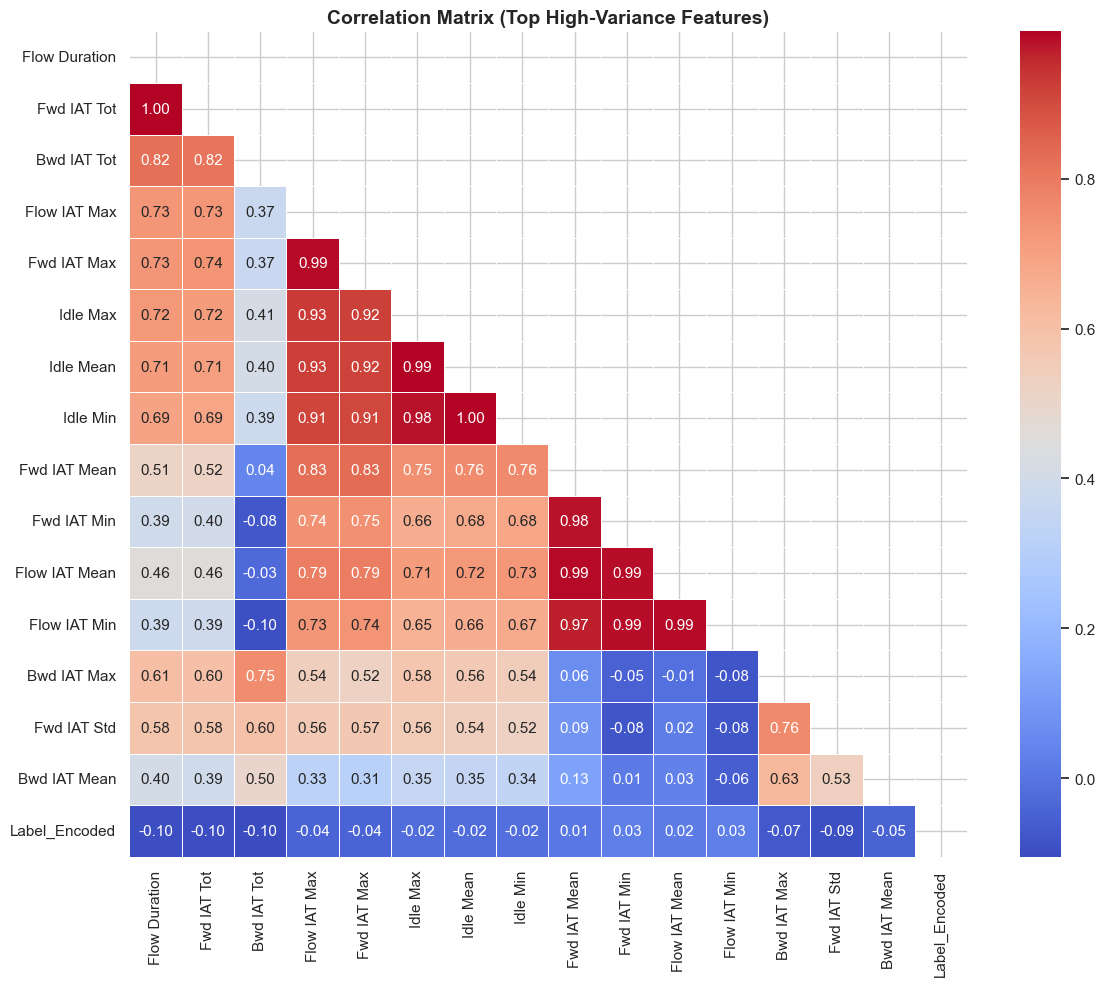

In [8]:
print("Generating Correlation Heatmap...")
plt.figure(figsize=(12, 10))

std_dev = df_vis[feature_cols].std()
top_var_cols = std_dev.sort_values(ascending=False).head(15).index.tolist()
cols_to_corr = top_var_cols + ['Label_Encoded']
corr_matrix = df_vis[cols_to_corr].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".2f",
    cmap='coolwarm', linewidths=0.5
)
plt.title("Correlation Matrix (Top High-Variance Features)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Generating Feature Distributions by Category...


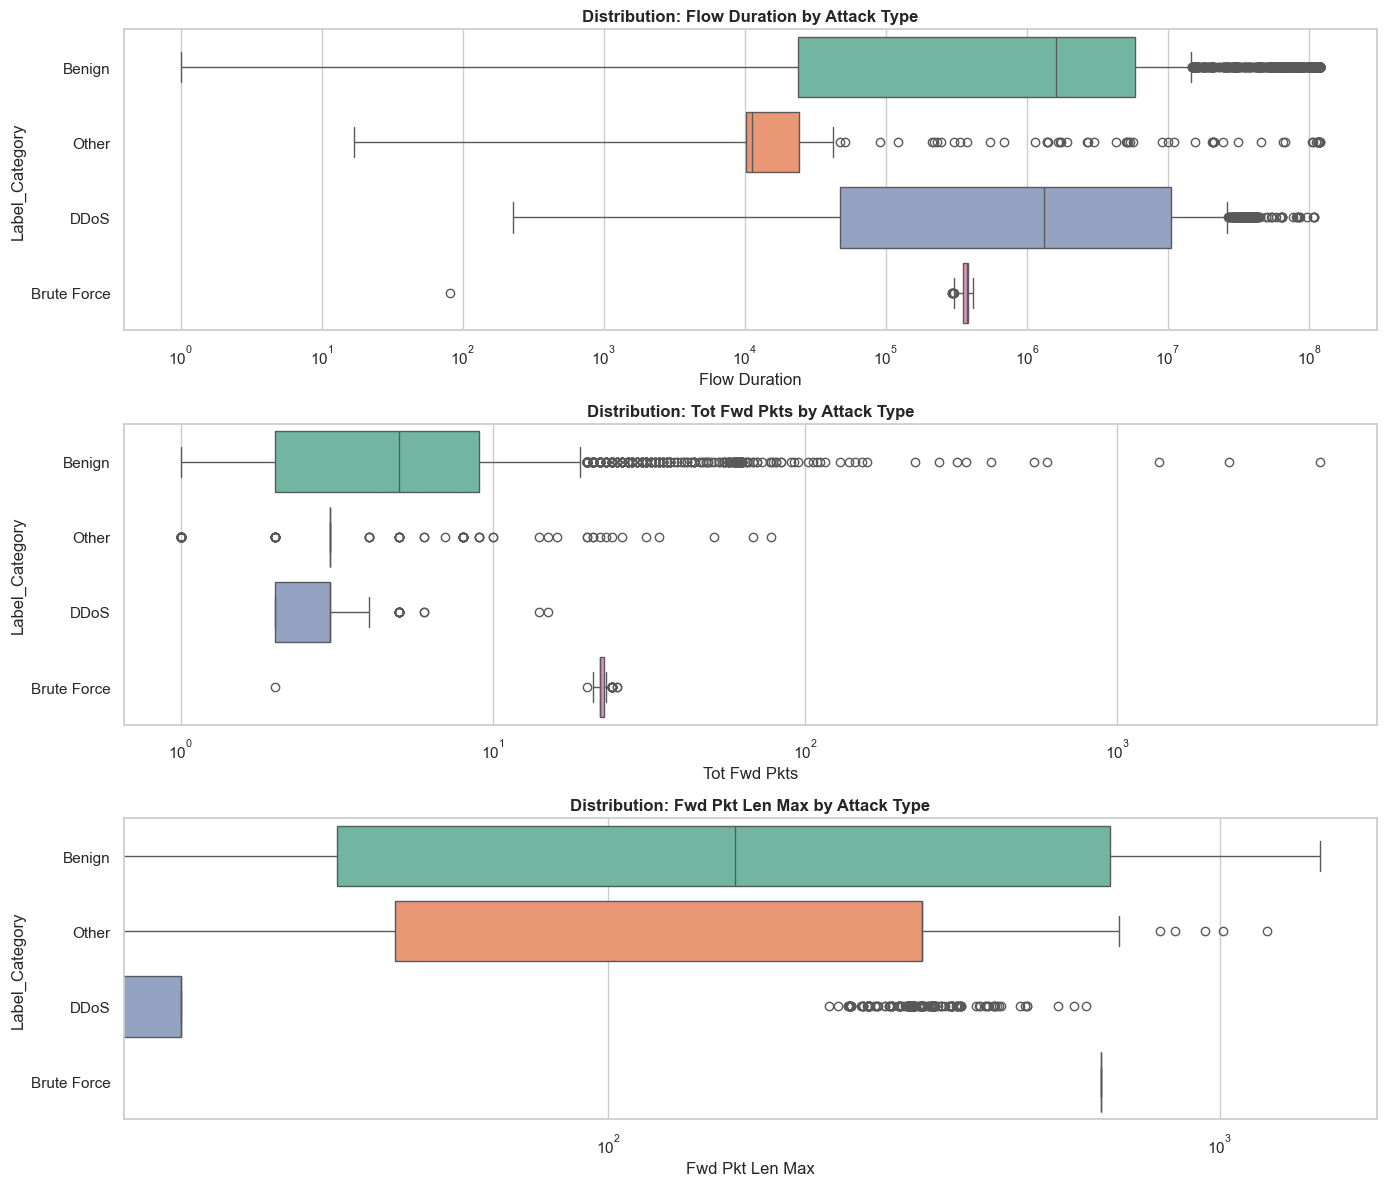

EDA Complete.


In [9]:
print("Generating Feature Distributions by Category...")
key_features = ['Flow Duration', 'Tot Fwd Pkts', 'Dst Port', 'Fwd Pkt Len Max']
plot_feats = [f for f in key_features if f in df_vis.columns]

if plot_feats:
    fig, axes = plt.subplots(nrows=len(plot_feats), ncols=1, figsize=(14, 4 * len(plot_feats)))
    if len(plot_feats) == 1:
        axes = [axes]
    
    for i, col in enumerate(plot_feats):
        sns.boxplot(
            data=df_vis, x=col, y='Label_Category',
            ax=axes[i], palette='Set2', orient='h'
        )
        axes[i].set_title(f'Distribution: {col} by Attack Type', fontsize=12, fontweight='bold')
        axes[i].set_xscale('log')
    
    plt.tight_layout()
    plt.show()

print("EDA Complete.")

---
# **5. Data Preparation**

Persiapan data untuk modeling meliputi:

### 5.1 Feature & Target Separation
- **Features (X)**: 78 fitur network flow (setelah drop kolom label)
- **Target (y)**: `Label_Encoded` (0-3)

### 5.2 Data Splitting
| Set | Proporsi | Fungsi |
|:---|:---:|:---|
| Training | 60% | Melatih model |
| Validation | 20% | Tuning hyperparameter |
| Test | 20% | Evaluasi performa final |

### 5.3 Preprocessing
- **Standard Scaling**: Normalisasi fitur ke mean=0, std=1
- **SMOTE**: Synthetic Minority Over-sampling Technique untuk menangani class imbalance

In [10]:
print("=" * 80)
print("                     FEATURE & TARGET PREPARATION")
print("=" * 80)

print("Verifying Label_Encoded mapping...")
label_mapping_df = ddf[['Label_Category', 'Label_Encoded']].drop_duplicates().compute().sort_values('Label_Encoded')
label_map_dict = dict(zip(label_mapping_df['Label_Encoded'], label_mapping_df['Label_Category']))

print("\nLabel Mapping:")
for code, name in label_map_dict.items():
    print(f"   {code} : {name}")

target_col = 'Label_Encoded'
excluded_columns = ['Label_Category', 'Label_Encoded', 'Label']
feature_cols = [col for col in ddf.columns if col not in excluded_columns]

X = ddf[feature_cols]
y = ddf[target_col]

print(f"\nTotal Features (X): {len(feature_cols)}")
print(f"Target Column (y): {target_col}")

                     FEATURE & TARGET PREPARATION
Verifying Label_Encoded mapping...

Label Mapping:
   0 : Benign
   1 : Brute Force
   2 : DDoS
   3 : Other

Total Features (X): 77
Target Column (y): Label_Encoded


In [11]:
print("\n[Splitting Data] Train (60%), Validation (20%), Test (20%)...")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

print("Calculating row counts...")
train_count = len(X_train)
val_count = len(X_val)
test_count = len(X_test)

print("-" * 40)
print(f"Train Set      : {train_count:,} rows")
print(f"Validation Set : {val_count:,} rows")
print(f"Test Set       : {test_count:,} rows")
print("-" * 40)


[Splitting Data] Train (60%), Validation (20%), Test (20%)...
Calculating row counts...
----------------------------------------
Train Set      : 309,503 rows
Validation Set : 103,294 rows
Test Set       : 102,688 rows
----------------------------------------


In [12]:
print("=" * 80)
print("                    SCALING & SMOTE OVERSAMPLING")
print("=" * 80)

target_names = ['Benign', 'Brute Force', 'DDoS', 'Other']
num_classes = len(target_names)

print("[INFO] Converting Dask to Pandas...")
start_time = time.time()

X_train_pd = X_train.compute().reset_index(drop=True)
y_train_pd = y_train.compute().reset_index(drop=True)
X_test_pd = X_test.compute().reset_index(drop=True)
y_test_pd = y_test.compute().reset_index(drop=True)

print(f"[INFO] Conversion Complete. Time: {time.time() - start_time:.2f}s")

print("[PREPROCESSING] Removing constant columns...")
std_dev = X_train_pd.std()
constant_cols = std_dev[std_dev == 0].index.tolist()
if constant_cols:
    X_train_pd.drop(columns=constant_cols, inplace=True)
    X_test_pd.drop(columns=constant_cols, inplace=True)
    print(f"   Dropped {len(constant_cols)} constant columns.")

print("[PREPROCESSING] Standard Scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pd)
X_test_scaled = scaler.transform(X_test_pd)

print("[IMBALANCE] Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_pd)

print(f"   Original Size: {X_train_pd.shape[0]:,} rows")
print(f"   SMOTE Size:    {X_train_smote.shape[0]:,} rows (Balanced)")

                    SCALING & SMOTE OVERSAMPLING
[INFO] Converting Dask to Pandas...
[INFO] Conversion Complete. Time: 5.05s
[PREPROCESSING] Removing constant columns...
   Dropped 8 constant columns.
[PREPROCESSING] Standard Scaling...
[IMBALANCE] Applying SMOTE...
   Original Size: 309,503 rows
   SMOTE Size:    1,078,960 rows (Balanced)


---
# **6. Modelling**

Empat algoritma klasifikasi digunakan untuk perbandingan performa:

| Model | Karakteristik | Kelebihan |
|:---|:---|:---|
| **Logistic Regression** | Linear classifier | Baseline, interpretable |
| **Decision Tree** | Non-linear, rule-based | Mudah divisualisasi |
| **Random Forest** | Ensemble of trees | Robust terhadap overfitting |
| **XGBoost** | Gradient boosting | State-of-the-art accuracy |

Setiap model dilatih menggunakan data yang sudah di-SMOTE untuk menangani class imbalance.

In [13]:
print("=" * 80)
print("                         MODEL TRAINING")
print("=" * 80)

models = {
    "Logistic Regression": LogisticRegression(
        solver='lbfgs', max_iter=500, n_jobs=-1, multi_class='multinomial'
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=20, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=20, n_jobs=-1, random_state=42
    ),
    "XGBoost": xgb.XGBClassifier(
        objective='multi:softprob', num_class=num_classes, tree_method='hist',
        n_jobs=-1, learning_rate=0.1, n_estimators=200, max_depth=10,
        reg_alpha=0.1, reg_lambda=1.0, subsample=0.8, random_state=42
    )
}

predictions = {}
probabilities = {}

for name, model in models.items():
    print(f"\n{'#' * 40}")
    print(f" TRAINING: {name}")
    print(f"{'#' * 40}")
    
    t0 = time.time()
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    
    predictions[name] = y_pred
    probabilities[name] = y_prob
    
    print(f"Training Time: {time.time() - t0:.2f} seconds")
    print(f"Accuracy: {accuracy_score(y_test_pd, y_pred):.4f}")

print("\nAll models trained successfully.")

                         MODEL TRAINING

########################################
 TRAINING: Logistic Regression
########################################
Training Time: 125.35 seconds
Accuracy: 0.8235

########################################
 TRAINING: Decision Tree
########################################
Training Time: 40.64 seconds
Accuracy: 0.9418

########################################
 TRAINING: Random Forest
########################################
Training Time: 81.09 seconds
Accuracy: 0.9599

########################################
 TRAINING: XGBoost
########################################
Training Time: 86.83 seconds
Accuracy: 0.9634

All models trained successfully.


---
# **7. Evaluation**

Evaluasi model dilakukan secara komprehensif menggunakan berbagai metrik:

### 7.1 Classification Report
- **Precision**: Proporsi prediksi positif yang benar
- **Recall**: Proporsi positif aktual yang terdeteksi
- **F1-Score**: Harmonic mean dari precision dan recall

### 7.2 Confusion Matrix
Visualisasi performa klasifikasi untuk setiap pasangan kelas (actual vs predicted)

### 7.3 ROC-AUC Curve
Receiver Operating Characteristic curve mengukur kemampuan model membedakan antar kelas

### 7.4 Feature Importance
Analisis fitur yang paling berpengaruh terhadap klasifikasi (XGBoost)

In [14]:
print("=" * 80)
print("                    DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for name, y_pred in predictions.items():
    print(f"\n{'=' * 60}")
    print(f" MODEL: {name}")
    print(f"{'=' * 60}")
    print(classification_report(y_test_pd, y_pred, target_names=target_names, digits=4))

                    DETAILED CLASSIFICATION REPORTS

 MODEL: Logistic Regression
              precision    recall  f1-score   support

      Benign     0.9910    0.8058    0.8888     89629
 Brute Force     0.9116    0.9945    0.9512       902
        DDoS     0.7978    0.9937    0.8850      9624
       Other     0.1118    0.7434    0.1944      2533

    accuracy                         0.8235    102688
   macro avg     0.7030    0.8843    0.7299    102688
weighted avg     0.9505    0.8235    0.8719    102688


 MODEL: Decision Tree
              precision    recall  f1-score   support

      Benign     0.9912    0.9418    0.9659     89629
 Brute Force     0.9858    0.9978    0.9917       902
        DDoS     0.9891    0.9990    0.9940      9624
       Other     0.2593    0.7055    0.3792      2533

    accuracy                         0.9418    102688
   macro avg     0.8063    0.9110    0.8327    102688
weighted avg     0.9729    0.9418    0.9543    102688


 MODEL: Random Forest
   

Generating Confusion Matrices...


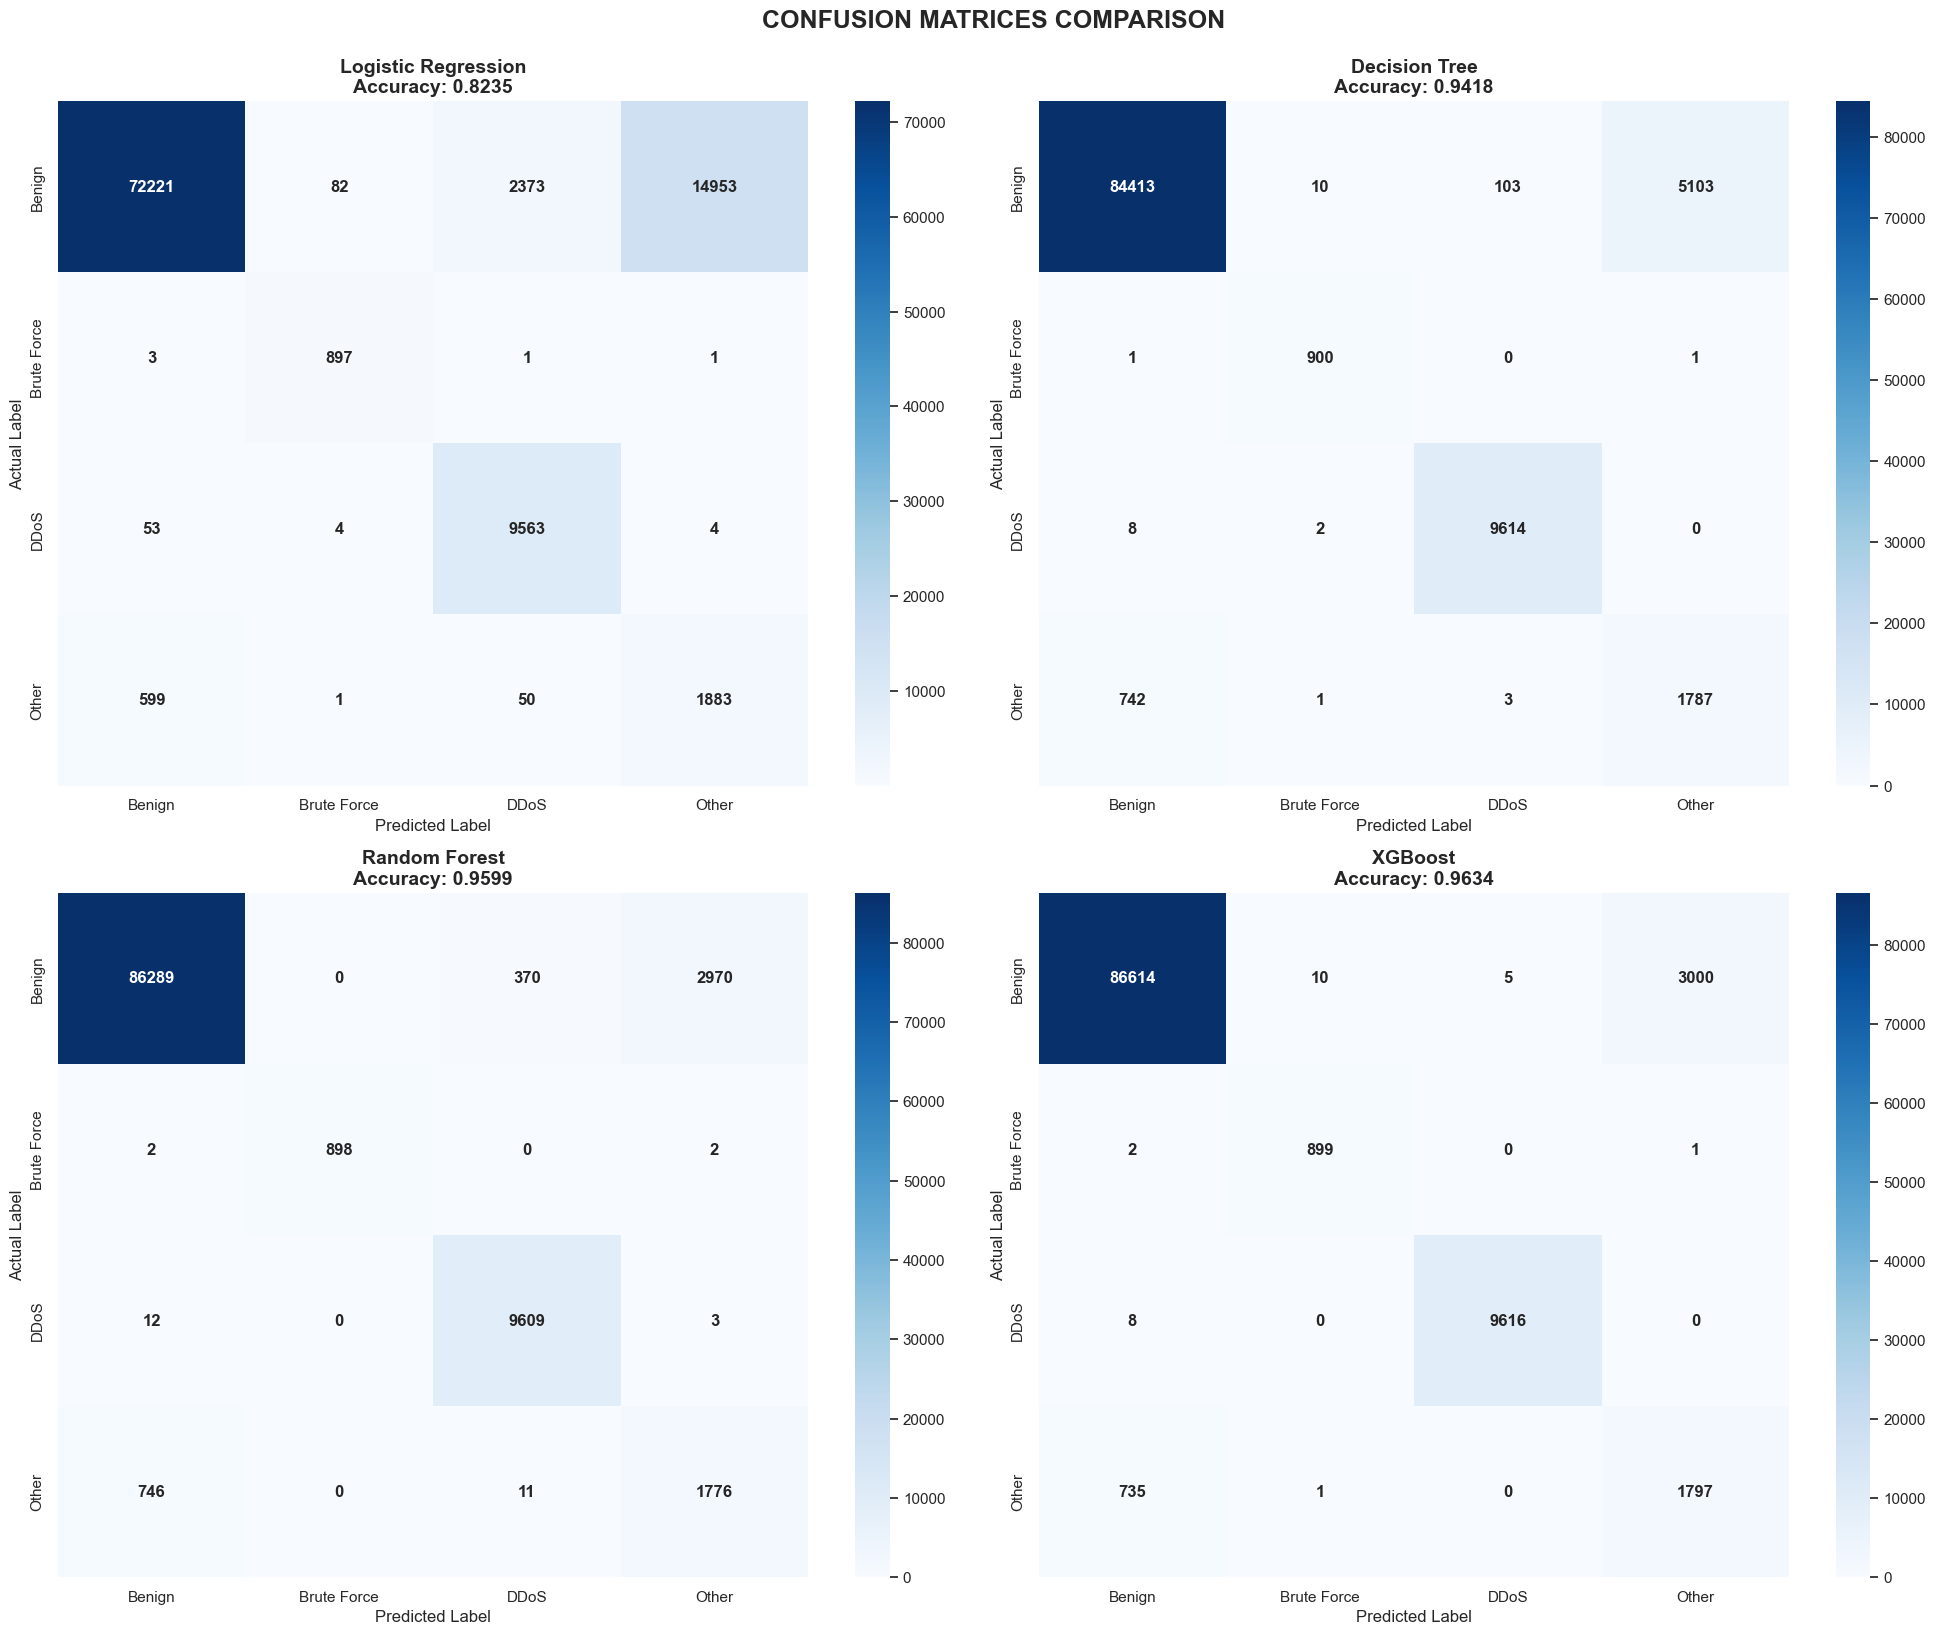

In [15]:
print("Generating Confusion Matrices...")

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test_pd, y_pred)
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
        annot_kws={"size": 12, "weight": "bold"},
        xticklabels=target_names, yticklabels=target_names
    )
    
    acc = accuracy_score(y_test_pd, y_pred)
    axes[i].set_title(f"{name}\nAccuracy: {acc:.4f}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Predicted Label", fontsize=12)
    axes[i].set_ylabel("Actual Label", fontsize=12)

plt.tight_layout()
plt.suptitle("CONFUSION MATRICES COMPARISON", y=1.02, fontsize=18, fontweight='bold')
plt.show()

Generating ROC-AUC Curves...


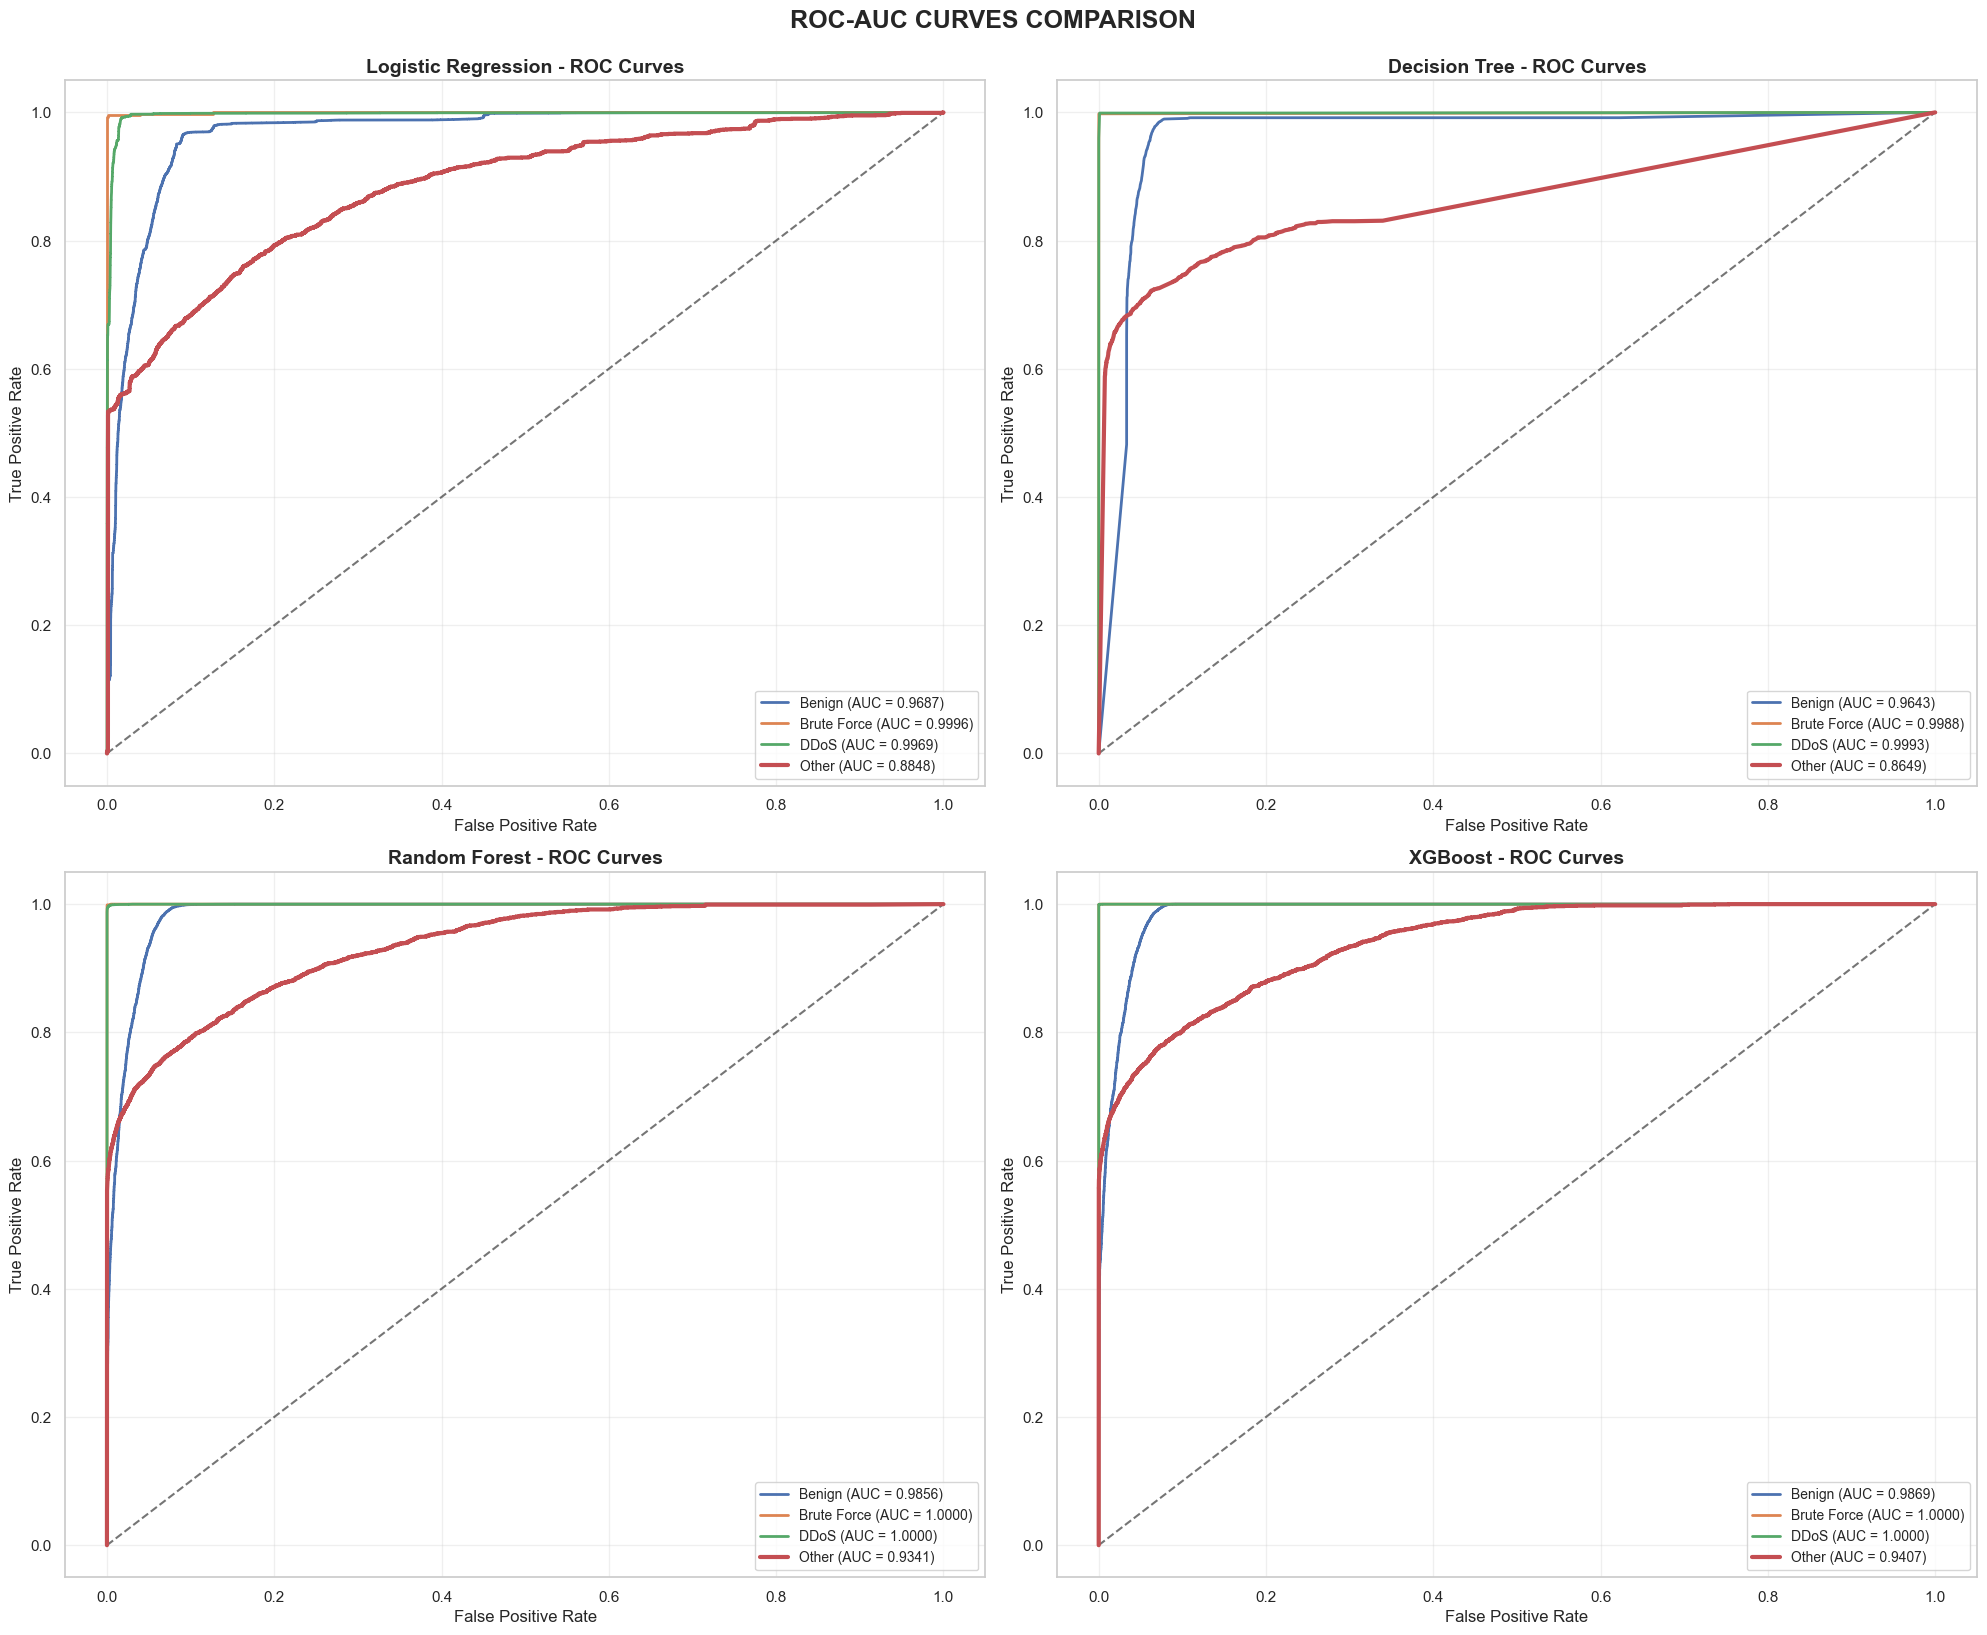

In [16]:
print("Generating ROC-AUC Curves...")

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()
y_test_bin = label_binarize(y_test_pd, classes=range(num_classes))

for i, (name, y_prob) in enumerate(probabilities.items()):
    ax = axes[i]
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6)
    
    for cls_idx in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, cls_idx], y_prob[:, cls_idx])
        roc_auc = auc(fpr, tpr)
        lw = 3 if cls_idx == 3 else 2
        ax.plot(fpr, tpr, lw=lw, label=f'{target_names[cls_idx]} (AUC = {roc_auc:.4f})')
    
    ax.set_title(f"{name} - ROC Curves", fontsize=14, fontweight='bold')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("ROC-AUC CURVES COMPARISON", y=1.02, fontsize=18, fontweight='bold')
plt.show()

Generating XGBoost Feature Importance...


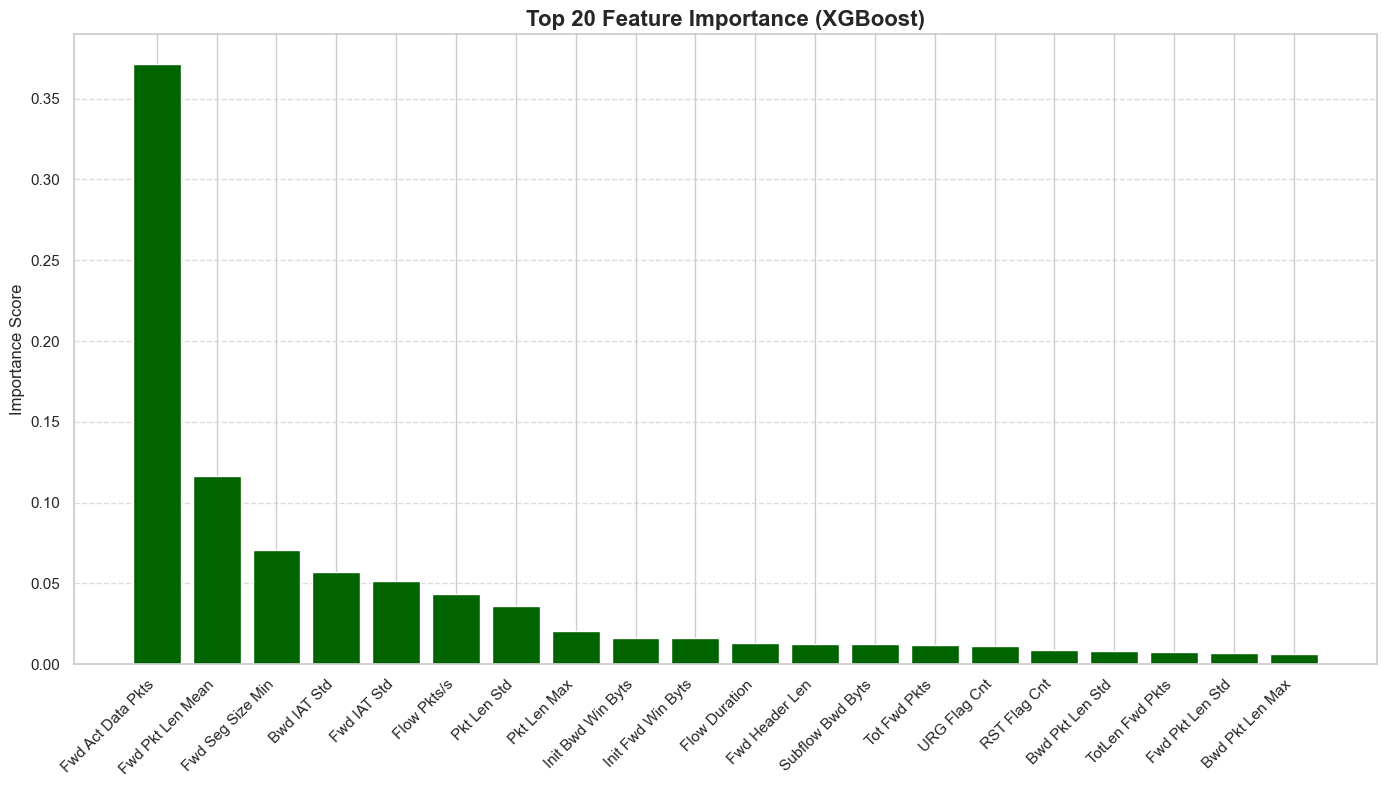

In [17]:
print("Generating XGBoost Feature Importance...")

feature_names = X_train_pd.columns.tolist()
xgb_model = models["XGBoost"]
importance = xgb_model.feature_importances_
indices = np.argsort(importance)[::-1][:20]

plt.figure(figsize=(14, 8))
plt.title("Top 20 Feature Importance (XGBoost)", fontsize=16, fontweight='bold')
plt.bar(range(20), importance[indices], align="center", color='#006400')
plt.xticks(range(20), [feature_names[i] for i in indices], rotation=45, ha='right', fontsize=11)
plt.ylabel("Importance Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

---
# **8. Save Models**

Model-model yang sudah dilatih disimpan ke disk menggunakan format `joblib` untuk deployment:

- **Scaler**: Diperlukan untuk preprocessing data baru
- **Trained Models**: Keempat model klasifikasi siap digunakan untuk inferensi

In [18]:
print("=" * 80)
print("                       SAVING MODELS TO DISK")
print("=" * 80)

save_dir = "saved_models_ids2018"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"[INFO] Created directory: {save_dir}")
else:
    print(f"[INFO] Using existing directory: {save_dir}")

scaler_path = os.path.join(save_dir, "scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"[SUCCESS] Scaler saved to: {scaler_path}")

print("\n[INFO] Saving trained models...")
for name, model in models.items():
    filename = name.lower().replace(" ", "_") + ".joblib"
    file_path = os.path.join(save_dir, filename)
    joblib.dump(model, file_path)
    file_size = os.path.getsize(file_path) / (1024 * 1024)
    print(f"   -> Saved: {filename:<30} | Size: {file_size:.2f} MB")

print("\n" + "=" * 80)
print(f"ALL MODELS SAVED SUCCESSFULLY TO '{save_dir}'")
print("=" * 80)

                       SAVING MODELS TO DISK
[INFO] Using existing directory: saved_models_ids2018
[SUCCESS] Scaler saved to: saved_models_ids2018\scaler.joblib

[INFO] Saving trained models...
   -> Saved: logistic_regression.joblib     | Size: 0.00 MB
   -> Saved: decision_tree.joblib           | Size: 1.11 MB
   -> Saved: random_forest.joblib           | Size: 118.00 MB
   -> Saved: xgboost.joblib                 | Size: 8.15 MB

ALL MODELS SAVED SUCCESSFULLY TO 'saved_models_ids2018'


---
# **Kesimpulan**

Notebook ini telah mendemonstrasikan pipeline lengkap untuk membangun sistem **Intrusion Detection System (IDS)** menggunakan dataset CSE-CIC-IDS2018.

### Ringkasan Hasil

| Model | Keunggulan |
|:---|:---|
| Logistic Regression | Baseline yang solid, cepat untuk training |
| Decision Tree | Mudah diinterpretasi, performa baik |
| Random Forest | Robust terhadap noise dan overfitting |
| XGBoost | Akurasi tertinggi, state-of-the-art |

### Catatan Implementasi

1. **SMOTE** berhasil menangani class imbalance yang ekstrem
2. **Feature Engineering** dapat ditingkatkan untuk performa lebih baik
3. Model-model sudah disimpan dan siap untuk **deployment**

---

**© 2024 - Josia Given Santoso (36230035) - Keamanan Data**